# Chapter 03 | 평가
이 챕터에서 사용된 sklearn 모듈과 메서드 정리

In [1]:
# 데이터 셋 로드
from sklearn.datasets import load_digits

# 전처리
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Binarizer

# ???
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split

# 모델 종류
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression

# 모델 평가
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score



In [2]:
import warnings
warnings.filterwarnings(action='ignore')

## 01. 정확도 accuracy

$정확도 = \frac{예측 결과가 동일한 데이터 건수}{전체 예측 데이터 건수}$

### 분류 모델의 성능 평가 지표로 '정확도'를 사용할 때 신중해야하는 이유
- titanic 예제에서 성별에 따라 1,0으로 예측하는 간단한 모델도 테스트 데이터의 구성에 따라서 높은 정확도를 가질 수 있다. *(아래의 예제1)*
- 정확도는 <U>불균형한 레이블 분포</U>에서 모델의 성능을 판단할 경우 적합한 평가 지표가 아니다.
    - 예를 들어 100개의 데이터 중에 90개의 데이터 레이블이 0, 10개의 데이터 레이블이 1일 경우, 무조건 0으로 결과를 예측하는 모델이라도 정확도가 90%가 나온다. *(MNIST 예제2)*

#### 예제1. 성별에 따라 1,0으로 예측하는 모델
- BaseEstimator 클래스를 상속받아 성별에 따라 생존자를 예측하는 단순한 Classifier을 생성
- 사이킷런에서 BaseEstimator를 상속받으면 사용자 정의된(Customized) 형태의 Estimator 생성 가능
- 생성할 MyDummyClassifier 클래스에서 학습을 수행하는 fit 메서드는 아무것도 수행하지 않으며, 예측을 수행하는 predict() 메서는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측하는 매우 단순한 Classifier

#### Q. BaseEsitmator가 무엇인지 궁금하다!
A. sklearn에서 fit과 predict를 포함한 메서드들을 정의한 모듈인 것 같다! 

In [3]:
import numpy as np

In [4]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        pred = np.zeros((X.shape[0],1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i]==1 :
                pred[i] == 0
            else :
                pred[i] == 1
                
        return pred

In [5]:
# 전처리 과정 함수로 만들기 *ch01-02_sklearn.ipynb*
from sklearn.preprocessing import LabelEncoder

# 결측치처리
def fillna(df):
    df['Age'].fillna(df["Age"].mean(), inplace=True) # Age 평균값 넣어주기
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna("N", inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 필요 없는 열 삭제 - PassengerId, Name, Ticket
def drop_features(df):
    df.drop(['PassengerId',"Name", "Ticket"], axis=1, inplace=True)
    return df

# 라벨인코딩 - Cabin, Sex, Embarked 
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    
    features = ['Cabin', "Sex",'Embarked']
    for feature in features :
        encoder = LabelEncoder()
        encoder.fit(df[feature])
        df[feature] = encoder.transform(df[feature])
        
#         print(feature)
#         print(encoder.classes_)
#         print(encoder.transform(encoder.classes_))
#         print()
        
    return df

# 전처리 진행
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    
    return df


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

tt_df = pd.read_csv("./titanic_train.csv")

y_tt_df = tt_df['Survived']
X_tt_df = tt_df.drop('Survived', axis=1)
X_tt_df = transform_features(X_tt_df)
X_train, X_test, y_train, y_test = train_test_split(X_tt_df, y_tt_df, test_size=0.2, random_state=0)

myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)
mypred = myclf.predict(X_test)
accuracy_score(y_test, mypred)

0.6145251396648045

#### 예제 2. MNIST
- 0~9까지 숫자 이미지의 픽셀 정보를 기반으로 숫자를 예측
- load_digits API를 이용해서 데이터셋 불러옴
- 원래 MNIST는 레이블 값이 0부터 9까지 있는 멀티 레이블 분류를 위한 것이지만, 이번 예제에서는 레이블이 7인 것만 True, 나머지 값은 모두 False 로 변환해 이진 분류 문제로 변형
- 즉, 전체 데이터의 10%만 True, 90%는 False인 불균형한 데이터 세트로 변경


In [7]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, x, y):
        pass
    
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)
    
# 데이터 로드    
digits = load_digits()

# .target : 레이블 데이터
# len(digits.target)

# 레이블 = 7인 것만 True(1), 나머지는 False(0)으로 만드는 과정 → 이진 분류 문제
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, test_size=0.2, random_state=11 )


In [8]:
# 불균형한 레이블 데이터 분포 확인
# np.unique(y_test, return_counts=True) # numpy value_counts
pd.Series(y_test).value_counts() # pandas value_counts

0    324
1     36
dtype: int64

In [9]:
fake_clf = MyFakeClassifier()
fake_clf.fit(X_train, y_train)
fake_pred = fake_clf.predict(X_test)
accuracy_score(y_test, fake_pred)
# get_clf_eval(y_test, fake_pred)

0.9

- 단순히 predict() 결과를 모두 0으로 반환하는 모델임에도 불구하고, 정확도가 90%로 나옴
- 결론 : __<U>정확도는 불균형한 레이블 데이터 세트에서는 모델 성능 평가 수치로 사용해서는 안된다.</U>__

## 02. 오차 행렬 confusion matrix
- 이진 분류에서 성능 지표로 잘 활용됨
- 학습된 분류 모델이 예측을 수행하면서 얼마나 confused하고 있는지를 보여주는 지표
- 예측 오류의 정도와 유형을 함께 나타냄

#### Q. 왜 클래스라고 하는거지? 
A. 클래스(class) : 출력될 수 있는 값들. 붓꽃의 종류들, 붓꽃의 종류는 세 클래스 중 하나에 속한다.  
레이블(label) : 데이터 포인트 하나(붓꽃 하나)에 대한 기대 출력. 특정 데이터 포인트에 대한 출력  
→ 예) 100개의 레이블 값을 unique하면 클래스가 나온다.


> 4분면 행렬에서 실제 레이블 클래스 값과 예측 레이블 클래스 값이 어떠한 유형을 가지고 매핑되는지를 나타냅니다.


<img src='https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F9908B7445E8BD68332' width="40%"> 

사진 출처 [링크](https://leedakyeong.tistory.com/entry/%EB%B6%84%EB%A5%98-%EB%AA%A8%EB%8D%B8-%EC%84%B1%EB%8A%A5-%ED%8F%89%EA%B0%80-%EC%A7%80%ED%91%9C-Confusion-Matrix%EB%9E%80-%EC%A0%95%ED%99%95%EB%8F%84Accuracy-%EC%A0%95%EB%B0%80%EB%8F%84Precision-%EC%9E%AC%ED%98%84%EB%8F%84Recall-F1-Score)

앞의 True/False 는 예측값과 실제값이 같은가/틀린가를 의미하고,  
뒤의 Negative/Positive는 예측 결과 값이 부정(0)/긍정(1)을 의미한다.

*Negative/Positive의 의미는 무엇인가???*

In [10]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, fake_pred)

array([[324,   0],
       [ 36,   0]])

무조건 0이라고 예측해서 맞은 것 True Negative 324개, 틀린 것 False Negative 36개이다.

*여기서 Negative는 0 및 False, Positive는 1 및 Ture을 의미하나보다.*

앞서 정확도는 예측값이 실제 값과 얼마나 동일한가에 대한 비율로만 결정되기 때문에 TN, TP에 좌우된다.
일반적으로 이러한 불균형한 레이블 클래스를 가지는 이진 분류 모델에서는 많은 데이터 중에서 <U>중점적으로 찾아야 하는 매우 적은 수의 레이블 값에 Postive 1을 부여하고, 그렇지 않은 경우 Negative 0을 부여한다.</U>  
- 예 1) 사기 행위 예측 모델에서 사기 행위가 Positive 1로, 정상 행위도 Negative 0으로 결정  
- 예 2) 암 검진 예측 모델에서 암이 양성일 경우 Positive 1로, 음성일 경우 Negative 0으로 결정  

불균형한 이진 분류 데이터 셋에서 Positive 데이터 건수가 매우 작기 때문에 이를 기반한 모델은 Positive 보다 Negative로 예측 정확도가 높아진다. 즉, Negative로 예측하는 경향이 더 강해져서 TN >> TP이 된다.  
결과적으로 '정확도' 지표는 (TN+TP)/All 이므로 TN만으로 정확도가 매우 높게 나와서 수치적인 판단 오류를 일으킨다.   

사기 행위나 암 검진 예측 모델에서와 같이 이진 분류 모델은 Positive를 정확하게 예측하는 것이 더 중요하기 때문에 Positive 에 대한 예측 정확도를 높이는 것이 더 중요하다. → positive 예측 성능에 초점을 둔 <U>'정밀도와 재현율'</U>    

## 03. 정밀도 precision 와 재현율 recall
- positive 데이터 세트의 예측 성능
- 앞서 만든 MyFakeClassifier는 Positive로 예측한 TP 값이 하나도 없기 때문에 정밀도와 재현율 값이 모두 0

$정밀도 precision = TP / (FP+TP)$ 
- Positive라고 예측한 대상 중 실제값이랑 일치한 데이터의 비율
    - 예 1) 사기라고 예측한 건수 중에 실제 사기였던 비율
    - 예 2) 암 양성이라고 예측한 case 중에 실제 암인 비율
- 정밀도가 중요한 지표일 경우 
    - 예) 스팸메일 판단 모델
- FP를 낮추는데 초점

$재현율 recall = TP / (FN+TP)$
- 실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율
    - 예 1) 실제로 사기였던 건수 중에 예측에 성공했던 건수의 비율
    - 예 2) 실제로 암이었던 case 중에 예측에 성공했던 case의 비율
- 재현율이 중요한 지표일 경우 = 실제 Positive 양성 데이터를 Negative로 잘못 판단하게 되면 업무상 영향을 받는 경우
    - 예) 금융 사기 적발 모델, 암 진단 모델
- FN을 낮추는데 초점

<img src='https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F9908B7445E8BD68332' width="40%"> 

사진 출처 [링크](https://leedakyeong.tistory.com/entry/%EB%B6%84%EB%A5%98-%EB%AA%A8%EB%8D%B8-%EC%84%B1%EB%8A%A5-%ED%8F%89%EA%B0%80-%EC%A7%80%ED%91%9C-Confusion-Matrix%EB%9E%80-%EC%A0%95%ED%99%95%EB%8F%84Accuracy-%EC%A0%95%EB%B0%80%EB%8F%84Precision-%EC%9E%AC%ED%98%84%EB%8F%84Recall-F1-Score)

```
# 정밀도 계산
precision_score()

# 재현율 계산
recall_score()

# confusion matrix, accuracy, precision, recall을 한꺼번에 호출
get_clf_eval()

```

In [11]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score

def get_clf_eval(y_test, pred):
    cfs = confusion_matrix(y_test, pred)
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred)
    rcl = recall_score(y_test, pred)
    
    print("confusion matrix:")
    print(cfs)
    print("accuracy:{:.4f}, precision:{:.4f}, recall:{:.4f} ".format(acc, prec, rcl))
    

In [12]:
# 회귀 모델
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

tt_df = pd.read_csv("titanic_train.csv")
y_tt_df = tt_df["Survived"]
X_tt_df = tt_df.drop("Survived", axis=1)
X_tt_df = transform_features(X_tt_df) # 전처리

X_train, X_test, y_train, y_test = train_test_split(X_tt_df, y_tt_df, test_size=0.2, random_state=11)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

get_clf_eval(y_test, lr_pred)

confusion matrix:
[[104  14]
 [ 13  48]]
accuracy:0.8492, precision:0.7742, recall:0.7869 


In [13]:
# 결정트리 모델
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
dt_pred = dtree.predict(X_test)
get_clf_eval(y_test, dt_pred)

confusion matrix:
[[101  17]
 [ 18  43]]
accuracy:0.8045, precision:0.7167, recall:0.7049 


In [14]:
# 랜덤포레스트 모델
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
get_clf_eval(y_test, rf_pred)

confusion matrix:
[[109   9]
 [ 16  45]]
accuracy:0.8603, precision:0.8333, recall:0.7377 


In [15]:
# 아까 MyDummyClassifier(성별에 따라서만 예측) 

myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)
mypred = myclf.predict(X_test)
get_clf_eval(y_test, mypred)

confusion matrix:
[[118   0]
 [ 61   0]]
accuracy:0.6592, precision:0.0000, recall:0.0000 


1. postivie(1)로 판단하게 없어서 precision과 recall 모두 0이 나오긴 했는데, precision 공식에 따르면 0/0이어서 계산이 안될 줄 알았는데 분자가 0이면 모두 0으로 되는 건지 오류 없이 0이 나오긴 한다. 내부적으로 어떻게 계산하는지 초큼 궁금???
2. 그림에서의 P/N 위치가 코드 결과와 반대로 되어 있다. 오른쪽 값들 → precision, 아래쪽 값들 → recall

### 정밀도/재현율 trade-off

분류 알고리즘에서,
- 각 데이터가 특정 레이블에 속하는지 각각의 확률(결정 확률?)을 구하여 예측 확률이 큰 레이블 값으로 최종 결정
- 예를 들어 이진 분류 모델에서 특정 데이터가 0이 될 확률이 10%, 1이 될 확률이 90%라면 최종 예측은 더 큰 확률을 가진 1로 예측
- 일반적으로 이진 분류에서는 임계값을 0.5 즉 50%로 정하고 이 기준보다 크면 Positive, 작으면 Negative
- `predict_proba()` : 개별 예측 확률 반환
    - 학습이 완료된 Classifier 객체에서 호출 가능
    - 테스트 피처(레이블) 데이터 세트를 입력
    - m X n ndarray 로 반환 (m : 입력 값의 레코드 수, n : 클래스 값 유형)
    - 각 열은 개별 클라스의 예측 확률
    - 이진 분류에서 첫번째 칼럼은 0 Negative 확률, 두번째 칼럼은 1 Positive 확률
    
*내피셜이긴 한데, python에서는 negative를 positive보다 선순위로 두는 것 같다. 0,1 순서라서 그런가...*
    


__cf. predict 결과물은 ndarray 타입__

In [16]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)

print("pred_proba dtype:", type(pred_proba))
print("pred_proba shape:", pred_proba.shape)
print("pred_proba head(3):", pred_proba[:3], sep='\n')

print()
print("pred dtype:", type(pred))
print("pred shape:", pred.shape)
print("pred head(3):", pred[:3], sep="\n")

# 예측 확률과 결과값을 병합
result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
result[:3]

pred_proba dtype: <class 'numpy.ndarray'>
pred_proba shape: (179, 2)
pred_proba head(3):
[[0.46196457 0.53803543]
 [0.87861802 0.12138198]
 [0.8771453  0.1228547 ]]

pred dtype: <class 'numpy.ndarray'>
pred shape: (179,)
pred head(3):
[1 0 0]


array([[0.46196457, 0.53803543, 1.        ],
       [0.87861802, 0.12138198, 0.        ],
       [0.8771453 , 0.1228547 , 0.        ]])

#### Q. concat의 문제인지 모르겠지만 reshape을 하는 이유를 잘 모르겠다.
A. `pred`를 reshape하기 전 shape을 찍어보면 (179,) 이건 그냥 1차 array이다. numpy.concatenate 문서를 살펴보면 (a1,a2...) 인자에 들어가는 array의 shape은 모두 동일해야한다고 말하고 있다. reshape을 통해서 pred_proba와 같은 2차원 형태으로 바꾸어주어야 한다.

<img width="500" alt="스크린샷 2021-07-13 오후 7 43 34" src="https://user-images.githubusercontent.com/38090151/125438940-44168128-d9b2-4b19-b012-892add2346f3.png" >


#### 결국 predict() 메서드는 predict_proba() 메서드에서 기반해서 생성된 API
predict()는 predict_proba() 호출 결과로 반환된 배열에서 <U>분류 결정 임계값(Classification Threshold)</U>보다 큰 값이 들어있는 칼럼의 위치를 받아서 최종적으로 예측   
→ <U>분류 결정 임계값</U>을 조절해 정밀도와 재현율의 성능 수치를 상호 보완적으로 조정

*예측 결과 나오면 그거를 count해서 TN, TP, FN, FP를 구하는 거니깐 Threshold를 조정하면 그 갯수도 조금씩 조정할 수 있겠구나!*

### Binarizer 
바이너라이저...  
*??? 어떤 모듈인지 잘 모르겠다. 그냥 threshold 적용시켜주는 모듈인가*

In [17]:
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
    [2, 0, 0],
    [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
bnz = Binarizer(threshold=1.1) # 객체 할당
bnz.fit_transform(X) # 학습 및 적용???

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

#### [summary] 임계값이 0.5 → 0.4로 감소하면,  
Positive 예측값이 많아지면서 상대적으로 recall 값이 높아진다. 
Positive 예측을 많이 하다보니 실제 양성을 음성으로 예측하는 횟수(FN 값)가/이 상대적으로 줄어들기 때문이다. 
- accruacy 감소 : 0.8492 → 0.8324
- precision 감소 : 0.7742 → 0.7183
- recall 증가 : 0.7869 → 0.8361 

In [18]:
cust_thr = 0.5

pred_proba1 = pred_proba[:,1].reshape(-1,1)
bnz = Binarizer(threshold=cust_thr).fit(pred_proba1)
cust_pred = bnz.transform(pred_proba1) # transform 할 때 2d array로

get_clf_eval(y_test, cust_pred)
# 앞의 결과와 동일! 임계값이 0.5로 default로 되어있었나보다

confusion matrix:
[[104  14]
 [ 13  48]]
accuracy:0.8492, precision:0.7742, recall:0.7869 


In [19]:
cust_thr = 0.4

pred_proba1 = pred_proba[:,1].reshape(-1,1)
bnz = Binarizer(threshold=cust_thr).fit(pred_proba1)
cust_pred = bnz.transform(pred_proba1) # transform 할 때 2d array로

get_clf_eval(y_test, cust_pred)

confusion matrix:
[[98 20]
 [10 51]]
accuracy:0.8324, precision:0.7183, recall:0.8361 


#### [summary] 임계값이 증가하면,
- accruacy 증가 
- precision 증가 
- recall 감소 

In [20]:
thresholds = [0.4, 0.45, 0.5, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for cust_thres in thresholds :
        bnz = Binarizer(threshold=cust_thres).fit(pred_proba_c1)
        cust_pred = bnz.transform(pred_proba_c1)
        print("threshold:", cust_thres)
        get_clf_eval(y_test, cust_pred)
        print()
        
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

threshold: 0.4
confusion matrix:
[[98 20]
 [10 51]]
accuracy:0.8324, precision:0.7183, recall:0.8361 

threshold: 0.45
confusion matrix:
[[103  15]
 [ 12  49]]
accuracy:0.8492, precision:0.7656, recall:0.8033 

threshold: 0.5
confusion matrix:
[[104  14]
 [ 13  48]]
accuracy:0.8492, precision:0.7742, recall:0.7869 

threshold: 0.55
confusion matrix:
[[109   9]
 [ 15  46]]
accuracy:0.8659, precision:0.8364, recall:0.7541 

threshold: 0.6
confusion matrix:
[[112   6]
 [ 16  45]]
accuracy:0.8771, precision:0.8824, recall:0.7377 



### precision_recall_curve()
- 타이타닉 예측 모델의 임곗값별 precision과 recall
- 0.11~0.95 threshold과 이에 해당하는 precision과 recall 값을 ndarray로 반환

In [21]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률 추출
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
print("반환된 thresholds의 배열의 shape:",thresholds.shape)

# 반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출, thresdhold를 15단계로 추출
thr_idx = np.arange(0, thresholds.shape[0], 15)
print("샘플 추출을 위한 thresholds 배열의 index:",thr_idx)
print("샘플 10개의 thresholds:", np.round(thresholds[thr_idx],2))
print("thresholds별 precision:", np.round(precisions[thr_idx],3))
print("thresholds별 recall:", np.round(recalls[thr_idx],3))


반환된 thresholds의 배열의 shape: (143,)
샘플 추출을 위한 thresholds 배열의 index: [  0  15  30  45  60  75  90 105 120 135]
샘플 10개의 thresholds: [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
thresholds별 precision: [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
thresholds별 recall: [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


### precision_recall_curve() 시각화

In [22]:
thresholds.shape

(143,)

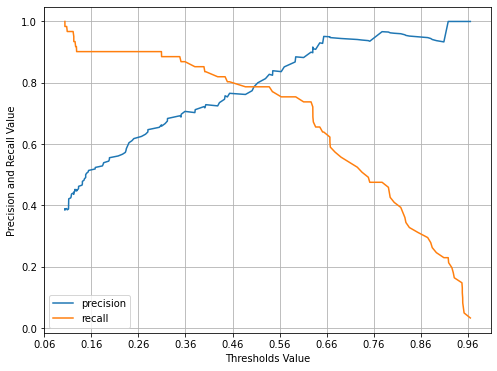

In [23]:
import matplotlib.pyplot as plt
# import matplotlib.ticker as ticker

def precision_recall_curve_plot(y_test, pred_proba_c1):
    
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[:threshold_boundary], label='precision')
    plt.plot(thresholds, recalls[:threshold_boundary ], label='recall')

    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))

    plt.xlabel("Thresholds Value")
    plt.ylabel("Precision and Recall Value")
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

- threshold가 낮을수록 많은 Positive 예측으로 recall 높아지고, precision 낮아짐
- 반면, threshold 증가할수록 많은 Negative 예측으로 recall 낮아지고, precision 높아짐

→ 하나의 성능 지표 수치만 높여서는 안된다. 서로 상호 보완할 수 있는 수준이어야한다. 
→ precision과 recall 수치가 적절하게 조합돼 분류의 종합적인 성능 평가에 사용되는 지표 : F1 스코어

## 04. F1 스코어

$F1 = \frac{1}{\frac{1}{recall}+\frac{1}{precision}} = 2 * \frac{precision*recall}{precision+recall}$
- precision과 recall이 어느 한쪽으로 치우지지 않는 수치를 나타낼 때 상대적으로 높은 값을 가짐
- 최댓값은 1

### f1_score()

In [24]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print(f1)

0.7804878048780488


#### threshold 바꾸어가면서 F1 스코어를 포함한 평가 지표 구해보기
- get_clf_eval() 함수에 F1 스코어를 구하는 로직을 추가

In [25]:
def get_clf_eval(y_test, pred):
    cfs = confusion_matrix(y_test, pred)
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred)
    rcl = recall_score(y_test, pred)
    
    # f1 추가
    f1 = f1_score(y_test, pred)
    
    print("confusion matrix:")
    print(cfs)
    print("accuracy:{:.4f}, precision:{:.4f}, recall:{:.4f}, F1:{:.4f} ".format(acc, prec, rcl, f1))

    
thresholds = [0.4, 0.45, 0.5, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)


threshold: 0.4
confusion matrix:
[[98 20]
 [10 51]]
accuracy:0.8324, precision:0.7183, recall:0.8361, F1:0.7727 

threshold: 0.45
confusion matrix:
[[103  15]
 [ 12  49]]
accuracy:0.8492, precision:0.7656, recall:0.8033, F1:0.7840 

threshold: 0.5
confusion matrix:
[[104  14]
 [ 13  48]]
accuracy:0.8492, precision:0.7742, recall:0.7869, F1:0.7805 

threshold: 0.55
confusion matrix:
[[109   9]
 [ 15  46]]
accuracy:0.8659, precision:0.8364, recall:0.7541, F1:0.7931 

threshold: 0.6
confusion matrix:
[[112   6]
 [ 16  45]]
accuracy:0.8771, precision:0.8824, recall:0.7377, F1:0.8036 



## 05. ROC 곡선과 AUC

- 일반적으로 이진 분류의 성능 평가를 위해 가장 많이 사용되는 지표
- ROC 곡선이 대각선 직선으로부터 멀어질수록 성능이 뛰어남
- AUC(Area Under Curve) 값은 ROC 곡선 밑의 면적, 1에 가까울수록 좋은 수치

In [28]:
from sklearn.metrics import roc_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]
fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

thr_idx = np.arange(1, thresholds.shape[0], 5)
print("샘플 추출을 위한 thresholds의 index:", thr_idx)
print("샘플 idx로 추출한 threshold:", np.round(thresholds[thr_idx],2))
print("샘플 idx별 FPR:", np.round(fprs[thr_idx],3))
print("샘플 idx별 TPR:", np.round(tprs[thr_idx],3))


샘플 추출을 위한 thresholds의 index: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플 idx로 추출한 threshold: [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 idx별 FPR: [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 idx별 TPR: [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


### ROC 곡선 시각화
- `roc_curve`

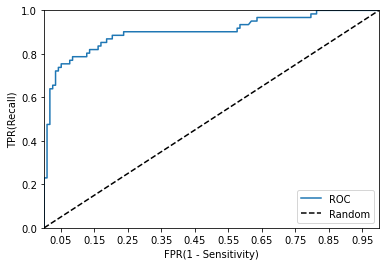

In [29]:
def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0,1],[0,1],'k--', label='Random')
    
    
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel("FPR(1 - Sensitivity)"); plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:,1])

### ROC 곡선 성능 지표 수치화 
- `roc_auc_score` 

In [30]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
print(roc_score)

0.9024034454015005


- get_clf_eval() 함수에 ROC_AUC를 구하는 로직을 추가

In [33]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    cfs = confusion_matrix(y_test, pred)
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred)
    rcl = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    
    print("confusion matrix:")
    print(cfs)
    print("accuracy:{:.4f}, precision:{:.4f}, recall:{:.4f}, F1:{:.4f}, AUC:{:.4f} ".format(acc, prec, rcl, f1, roc_auc))


get_clf_eval(y_test, pred, pred_proba)
    

confusion matrix:
[[104  14]
 [ 13  48]]
accuracy:0.8492, precision:0.7742, recall:0.7869, F1:0.7805, AUC:0.9024 


## 06. 피마 인디언 당뇨병 예측

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


In [38]:
diabetes = pd.read_csv("diabetes.csv")
print(diabetes["Outcome"].value_counts())
diabetes.head()

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [39]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [42]:
X = diabetes.iloc[:,:-1]
y = diabetes.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

lr_clf = LogisticRegression()
lr_clf.fit(X_train ,y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

confusion matrix:
[[88 12]
 [23 31]]
accuracy:0.7727, precision:0.7209, recall:0.5741, F1:0.6392, AUC:0.7919 


#### 결과를 보고 저자의 판단
> 전체 데이터의 65%가 Negative이므로 정확도보다는 재현율의 성능에 조금 더 초점을 맞춰보겠습니다.

해석 : y.value_counts()해보면 Negative:Positive = 500:268 이므로 Negative가 대략 65%를 차지한다. precision과 recall의 공식을 살펴보면 Negative에 의존하는 지표가 recall 이기 때문에 이를 높이기 위해 시도해본다고 이해할 수 있겠다.

> 먼저 정밀도 재현율 곡선을 보고 임곗값별 정밀도와 재현율 값의 변화를 확인하겠습니다. 이를 위해 `precision_recall_curve_plot()`을 이용하겠습니다.


(154,)
<class 'numpy.ndarray'>


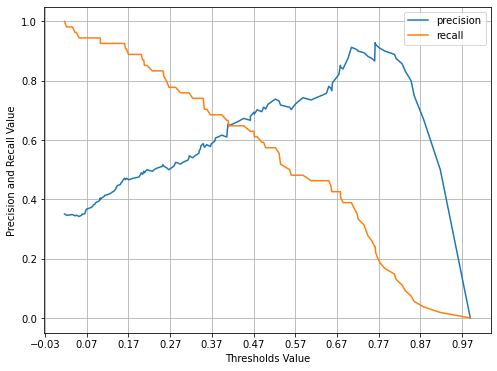

In [48]:
print(pred_proba.shape)
print(type(pred_proba))
precision_recall_curve_plot(y_test, pred_proba)

> 임계값이 0.42정도로 낮추면 정밀도와 재현율이 어느 정도 균형을 맞춤. 하지만 두 개의 지표 모두 0.7으로 다소 낮은 수치 인계값을 조작하기 전에 다시 데이터 값 점검.

In [51]:
diabetes.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


> 포도당 수치 Glucose 피어가 0(min)인 데이터가 일정 수준 존재함. 전체 데이터 건수 대비 몇 퍼센트의 비율로 존재하는지 확인

array([[<AxesSubplot:title={'center':'Pregnancies'}>,
        <AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'BloodPressure'}>],
       [<AxesSubplot:title={'center':'SkinThickness'}>,
        <AxesSubplot:title={'center':'Insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Outcome'}>]], dtype=object)

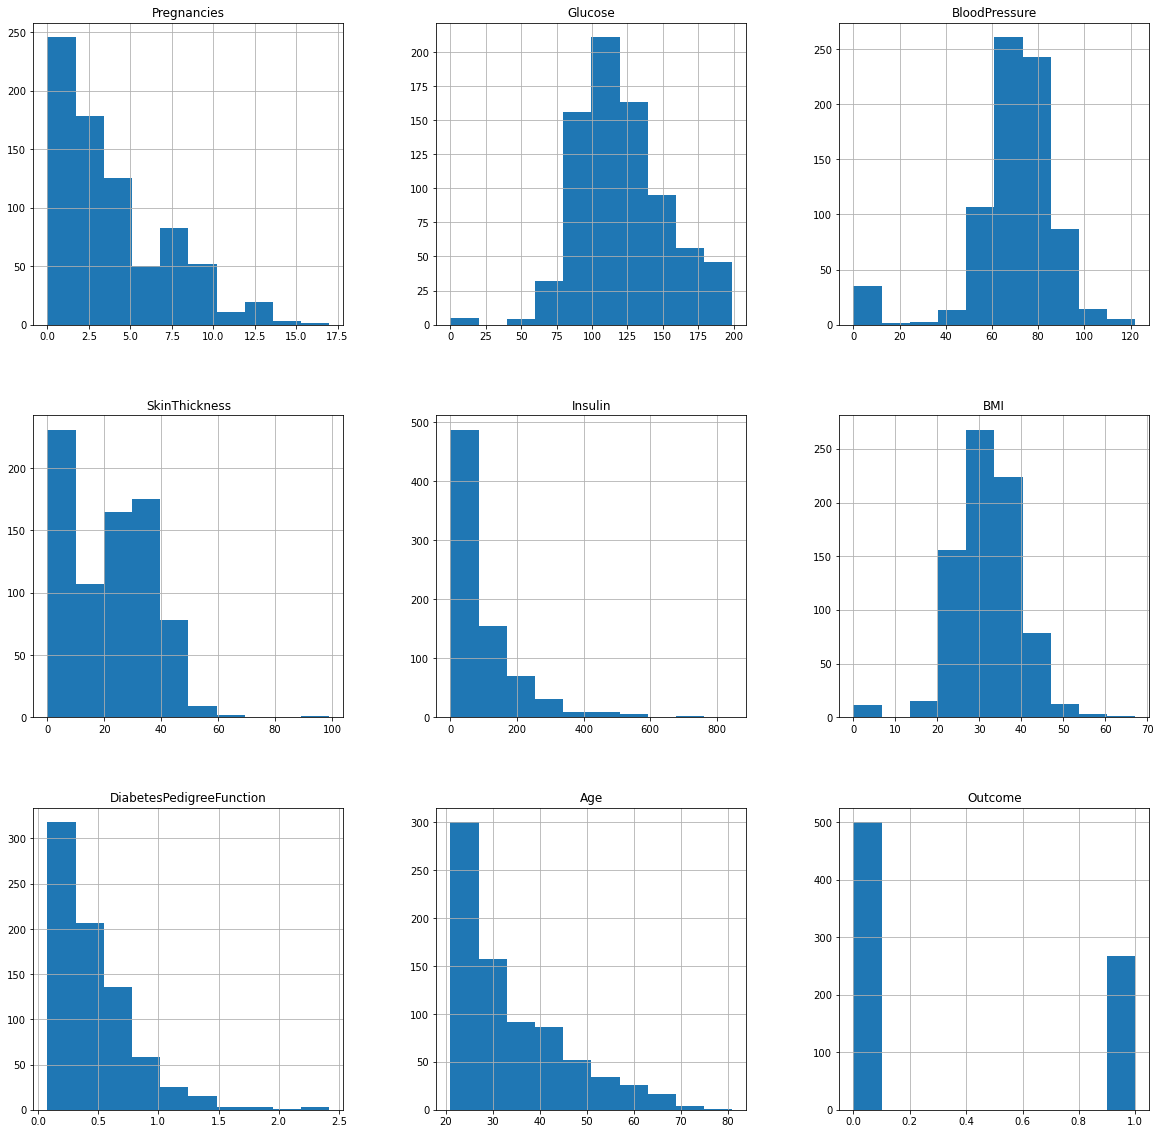

In [57]:
diabetes.hist(figsize=(20,20))
# plt.hist(diabetes['Glucose'])

In [64]:
# 0 값을 검사할 피처 명 리스트
zero_features = ['Glucose','BloodPressure','SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes['Glucose'].count()


for feature in zero_features:
    zero_count = diabetes[diabetes[feature]==0][feature].count()
    print(f"{feature} : {zero_count}({np.round(100*zero_count/total_count,2)}%)")

Glucose : 5(0.65%)
BloodPressure : 35(4.56%)
SkinThickness : 227(29.56%)
Insulin : 374(48.7%)
BMI : 11(1.43%)


> SkinThickness와 Insulin은 0의 값이 전체의 29%, 48%를 차지. 위 피처의 0값을 평균값으로 대체.

In [65]:
mean_zero_features = diabetes[zero_features].mean()
diabetes[zero_features] = diabetes[zero_features].replace(0, mean_zero_features)

#### 다시

In [66]:
X = diabetes.iloc[:,:-1]
y = diabetes.iloc[:,-1]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)

lr_clf = LogisticRegression()
lr_clf.fit(X_train ,y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

confusion matrix:
[[90 10]
 [21 33]]
accuracy:0.7987, precision:0.7674, recall:0.6111, F1:0.6804, AUC:0.8433 


> 데이터 변환과 스케일링을 통해 성능 수치가 일정 수준 개선
### threshold

In [75]:
thresholds= [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
# get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

In [76]:
bnz = Binarizer(threshold=0.48)
pred_th_48 = bnz.fit_transform(pred_proba[:,1].reshape(-1,1))
get_clf_eval(y_test, pred_th_48, pred_proba[:,1])

confusion matrix:
[[88 12]
 [19 35]]
accuracy:0.7987, precision:0.7447, recall:0.6481, F1:0.6931, AUC:0.8433 
